## 3-1. 협업 필터링의 원리

협업 필터링(CF: Collaborative Filtering) : 어떤 아이템에 대해서 비슷한 취향을 가진 사람들은 다른 아이템에 대해서도 비슷한 취향을 가지고 있을 것이라 가정하여, 취향을 기준으로 추천하는 알고리즘  

1. A와 취향이 비슷한 사용자(neighbor)를 찾자. 즉, 사용자 간 유사도가 높은 사용자를 찾자. (e.g. 영화에 대한 평가의 유사성 계산)
2. 취향이 비슷한 사용자들이 공통적으로 좋아하는 제품을 찾자. (e.g. 취향이 비슷한 사용자들이 좋게 평가한 영화를 찾기)
3. 공통적으로 좋아한 제품을 A에게 추천하자.

## 3-2. 유사도지표

CF에서는 사용자들의 평가를 기반으로 사용자 간 유사도를 구하는 것이 핵심이다.  
CF에서는 다양한 사용자 간의 유사도 지표(similarity index)를 사용할 수 있는데, 이 중에서 중요한 유사도지표에 대해서 아래에 설명한다.

1. 상관계수 (correlation coefficient)  
- 평가 자료가 연속값인 경우, 가장 이해하기 쉬운 유사도   

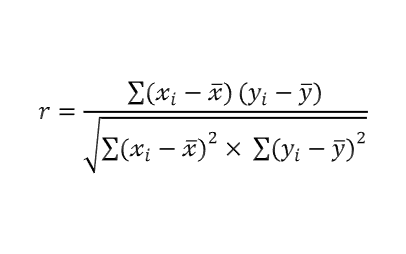  
- x, y: 유사도의 계산 대상이 되는 두 사용자
- xi, yi: 두 사용자가 공통으로 평가한 아이템 중에서 i번째 아이템에 대한 이 두 사용자의 평가 값
- 상관계수는 최소 -1(완전 반대)에서 최대 1(완전 일치)까지의 값을 가짐

2. 코사인 유사도 (cosine similarity)  
- 평가 자료가 연속값인 경우, CF에서 가장 널리 쓰이는 유사도  

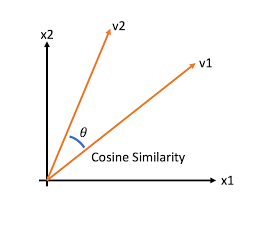
- 각 아이템을 하나의 차원으로 보고, 사용자의 평가값을 좌표 값으로 봄
- 각 사용자의 평가값을 벡터로 표현 가능
- 두 사용자의 평가값이 유사할수록 각도가 작아지기에 코사인값이 커짐  

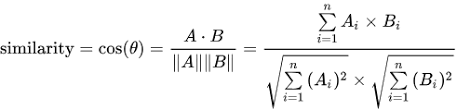
- A, B: 유사도 대상이 되는 두 사용자이고
- Ai, Bi: 두 사용자가 공통적으로 평가한 아이템 중 i번째 아이템에 대한 평가 값


3. 타니모토 계수 (Tanimoto coefficient)  

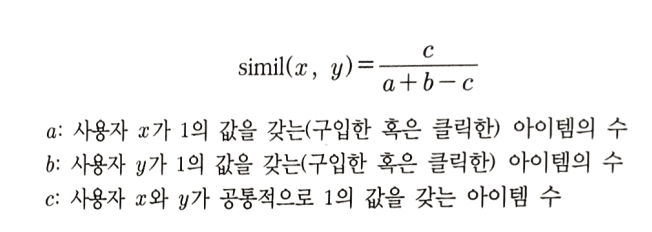  

- 평가 자료가 이진값인 경우 널리 사용되는 유사도  
- 이진수 데이터에 대해서 CF에서 상당히 좋은 결과를 보여줌
- 최소 0 (완전 불일치) ~ 최대 1 (완전 일치)
- 타니모토 계수의 변형으로 자카드 계수가 있음


## 3-3. 기본 CF 알고리즘

가장 기본적인 CF 알고리즘은 위에서 설명한 것 중에서 이웃을 전체 사용자로 한다.  
즉, 현재 사용자와 취향이 비슷한 사용자 그룹을 따로 선정하지 않고 모든 사용자의 평점을 가지고 예측을 한다. 
1. 모든 사용자 간의 평가의 유사도를 계산
2. 현재 추천 대상이 되는 사람과 다른 사용자의 유사도를 추출
3. 현재 사용자가 평가하지 않은 모든 아이템에 대해 현재 사용자의 예상 평가값을 구함  
    (예상 평가값: 다른 사용자의 해당 아이템에 대한 평가를 현재 사용자와 그 사용자와의 유사도로 가중해서 평균을 낸 값)
4. 아이템 중 예상 평가값이 가장 높은 N개의 아이템을 추천

In [2]:
# Created or modified on May 2022
# Author: 임일
# 협업필터링(CF) 추천 - 기본

################# 앞 장 동일: 데이터 읽어오기, RMSE 계산, full matrix로 변환
import numpy as np
import pandas as pd

# 데이터 읽어 오기 
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('../Data/u.user', sep='|', names=u_cols, encoding='latin-1')
i_cols = ['movie_id', 'title', 'release date', 'video release date', 'IMDB URL', 'unknown', 
        'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 
        'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
        'Thriller', 'War', 'Western']
movies = pd.read_csv('../Data/u.item', sep='|', names=i_cols, encoding='latin-1')
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('../Data/u.data', sep='\t', names=r_cols, encoding='latin-1')

# timestamp 제거 
ratings = ratings.drop('timestamp', axis=1)
# movie ID와 title 빼고 다른 데이터 제거
movies = movies[['movie_id', 'title']]

# train, test 데이터 분리
from sklearn.model_selection import train_test_split
x = ratings.copy()
y = ratings['user_id']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y)

# 정확도(RMSE)를 계산하는 함수 
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

# 모델별 RMSE를 계산하는 함수 
def score(model):
    id_pairs = zip(x_test['user_id'], x_test['movie_id'])
    y_pred = np.array([model(user, movie) for (user, movie) in id_pairs])
    y_true = np.array(x_test['rating'])
    return RMSE(y_true, y_pred)

# train 데이터로 Full matrix 구하기 
rating_matrix = x_train.pivot(index='user_id', columns='movie_id', values='rating')

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [12]:

################# 코사인 유사도로 유사도 계산하여 추천

from sklearn.metrics.pairwise import cosine_similarity  # 코사인 유사도를 구하기 위해 import
matrix_dummy = rating_matrix.copy().fillna(0)
# 1. 모든 사용자 간의 코사인 유사도를 구함
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)

def CF_simple(user_id, movie_id):   # '해당 user의 해당 movie에 대한 예상 평점'을 계산(가중평균)해서 돌려주는 함수
    if movie_id in rating_matrix:   # 해당 movie를 rating한 데이터가 훈련데이터에 있다면
        # 2. 현재 사용자와 다른 사용자 간의 similarity 가져오기
        sim_scores = user_similarity[user_id].copy()
        # 현재 영화에 대한 모든 사용자의 rating값 가져오기
        movie_ratings = rating_matrix[movie_id].copy()
        # 현재 영화를 평가하지 않은 사용자의 index 가져오기
        none_rating_idx = movie_ratings[movie_ratings.isnull()].index
        # 현재 영화를 평가하지 않은 사용자의 rating (null) 제거
        movie_ratings = movie_ratings.dropna()
        # 현재 영화를 평가하지 않은 사용자의 similarity값 제거
        sim_scores = sim_scores.drop(none_rating_idx)
        # 3. 현재 영화를 평가한 모든 사용자의 가중평균값 구하기
        mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
    else:
        mean_rating = 3.0
    return mean_rating

# 예측 정확도 계산
score(CF_simple)

1.0223780694416973

RMSE가 약 1.022로서 성별이나 직업별 평균을 사용한 경우보다 상당히 개선되었음을 알 수 있음.  
즉 평가경향이 비슷한(유사도가 높은) 사용자에게 가중치를 더 주어서 평균을 계산하면 더 정확한 예측을 할 수 있음.

## 3-4. 이웃을 고려한 CF

#### 3-3보다 정확한 이웃을 고려한 CF

3-3에서는 전체 사용자와의 유사도를 바탕으로 가중평균을 이용하여 평점을 예측했다.  
3-3의 CF 알고리즘을 개선할 수 있는 한 가지 방법은 '**사용자 중에서 유사도가 높은 사용자를 선정해서 그 사람들의 평점만 가지고** 예측을 하는 것'이다!  
이렇게 사용자와 유사도가 높은 사람의 평가만 사용하면 당연히 예측의 정확도가 올라간다.  


#### 이웃을 정하는 기준

1. kNN(K Nearest Neighbor): 이웃의 크기(k)를 미리 정해 놓고 추천 대상 사용자와 가장 유사한 K명을 선택
2. Thresholding: 유사도의 기준(e.g.상관계수 0.8 이상)을 정해 놓고 이 기준을 충족시키는 사용자를 이웃으로 정함

Thresholding이 kNN보다 정확.  
But, 정해진 유사도 기준을 넘는 사용자가 없어서 추천을 하지 못하는 경우가 많기 때문에 **kNN이 무난하게 많이 쓰임.**


#### 이웃을 고려한 CF Code (kNN)

1. 모든 사용자 간의 평가의 유사도를 계산
2. 현재 추천 대상이 되는 사람과 다른 사용자의 유사도를 추출
3. 현재 사용자가 평가하지 않은 모든 아이템에 대해 현재 사용자의 예상 평가값을 구함  
    (예상 평가값: 유사도가 큰 k명의 해당 아이템에 대한 평가를 현재 사용자와 그 사용자와의 유사도로 가중해서 평균을 낸 값)
4. 아이템 중 예상 평가값이 가장 높은 N개의 아이템을 추천

In [14]:
# Created or modified on May 2022
# Author: 임일
# 협업필터링(CF) 추천 - KNN

##################### 반복코드
import numpy as np
import pandas as pd

# 데이터 읽어 오기 
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('../Data/u.user', sep='|', names=u_cols, encoding='latin-1')
i_cols = ['movie_id', 'title', 'release date', 'video release date', 'IMDB URL', 'unknown', 
        'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 
        'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
        'Thriller', 'War', 'Western']
movies = pd.read_csv('../Data/u.item', sep='|', names=i_cols, encoding='latin-1')
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('../Data/u.data', sep='\t', names=r_cols, encoding='latin-1')

# timestamp 제거 
ratings = ratings.drop('timestamp', axis=1)
# movie ID와 title 빼고 다른 데이터 제거
movies = movies[['movie_id', 'title']]
movies = movies.set_index('movie_id')

# train, test 데이터 분리
from sklearn.model_selection import train_test_split
x = ratings.copy()
y = ratings['user_id']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y)

# 정확도(RMSE)를 계산하는 함수 
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

# 모델별 RMSE를 계산하는 함수 (score함수에 neighbor_size 추가 ver.)
def score(model, neighbor_size=0):
    id_pairs = zip(x_test['user_id'], x_test['movie_id'])
    # 예측할 때 전체 사용자x, 현재유저와 유사도가 높은 k명만을 기반으로 예측
    y_pred = np.array([model(user, movie, neighbor_size) for (user, movie) in id_pairs])
    y_true = np.array(x_test['rating'])
    return RMSE(y_true, y_pred)

# train 데이터로 Full matrix 구하기 
rating_matrix = x_train.pivot(index='user_id', columns='movie_id', values='rating')

# train set 사용자들의 Cosine similarities 계산
from sklearn.metrics.pairwise import cosine_similarity
matrix_dummy = rating_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [23]:

##################### 새로운 코드 (kNN 예측치의 정확도 계산)

# Neighbor size를 정하여(k-NN) 예측치를 계산하는 함수 
# neighbor_size=0인 경우 전체 사용자 데이터 사요하는 3-3과 동일
def cf_knn(user_id, movie_id, neighbor_size=0): 
    if movie_id in rating_matrix:
        # 현재 사용자와 다른 사용자 간의 similarity 가져오기
        sim_scores = user_similarity[user_id].copy()
        # 현재 영화에 대한 모든 사용자의 rating값 가져오기
        movie_ratings = rating_matrix[movie_id].copy()
        # 현재 영화를 평가하지 않은 사용자의 index 가져오기
        none_rating_idx = movie_ratings[movie_ratings.isnull()].index
        # 현재 영화를 평가하지 않은 사용자의 rating (null) 제거
        movie_ratings = movie_ratings.drop(none_rating_idx)
        # 현재 영화를 평가하지 않은 사용자의 similarity값 제거
        sim_scores = sim_scores.drop(none_rating_idx)
        ##### 1. Neighbor size가 지정되지 않은 경우        
        if neighbor_size == 0:          
            # 현재 영화를 평가한 모든 사용자의 가중평균값 구하기
            mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
        ##### 2. Neighbor size가 지정된 경우
        else:                       
            # 해당 영화를 평가한 사용자가 최소 2명이 되는 경우에만 계산
            if len(sim_scores) > 1: 
                # 이웃의 수를 'neighbor size 값'과 '해당 영화를 평가한 총사용자 수' 중 작은 것으로 결정
                neighbor_size = min(neighbor_size, len(sim_scores))
                # array로 바꾸기 (argsort를 사용하기 위함)
                sim_scores = np.array(sim_scores)       # 현재 사용자와 다른 사용자간의 유사도(null제외)
                movie_ratings = np.array(movie_ratings) # 해당 영화에 대한 모든 사용자의 평가(null제외)
                # 현 사용자와 유사도를 오름차순으로 정렬
                # argsort(): 배열을 오름차순 정렬했을 때, 각 원소의 정렬된 인덱스를 반환
                user_idx = np.argsort(sim_scores)
                # 유사도를 neighbor size만큼 받기 (오름차순이므로 뒤에서 k개 가져오기)
                sim_scores = sim_scores[user_idx][-neighbor_size:]
                # 영화 rating을 neighbor size만큼 받기
                movie_ratings = movie_ratings[user_idx][-neighbor_size:]
                # 최종 예측값 계산 
                mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
            else:
                mean_rating = 3.0
    else:
        mean_rating = 3.0
    return mean_rating

# 정확도 계산
score(cf_knn, neighbor_size=30)

0.9077407937300228

3-3보다 값이 작으므로 이웃의 크기를 고려하지 않는 simple_CF()보다 RMSE가 개선되었음을 볼 수 있다.

In [24]:
##################### 새로운 코드 (kNN으로 해당 사용자에게 아이템 추천)

# 전체 데이터로 full matrix와 cosine similarity 구하기 
# 실제 추천을 할 때엔 train/test set을 나눌 필요가 없기 때문
rating_matrix = ratings.pivot_table(values='rating', index='user_id', columns='movie_id')

from sklearn.metrics.pairwise import cosine_similarity
matrix_dummy = rating_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
# 전체 유저간의 유사도
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)

# 사용자ID, 추천아이템 수, 이웃 크기를 파라미터로 받고 주어진 사용자에 대한 추천 아이템을 반환하는 함수
def recommender(user, n_items=10, neighbor_size=20):
    # 현재 사용자의 모든 아이템에 대한 예상 평점 계산
    predictions = []
    rated_index = rating_matrix.loc[user][rating_matrix.loc[user] > 0].index    # 이미 평가한 영화 확인
    items = rating_matrix.loc[user].drop(rated_index)
    for item in items.index:
        predictions.append(cf_knn(user, item, neighbor_size))                   # 예상평점 계산
    recommendations = pd.Series(data=predictions, index=items.index, dtype=float)
    recommendations = recommendations.sort_values(ascending=False)[:n_items]    # 예상평점이 높은 영화 n개 선택
    recommended_items = movies.loc[recommendations.index]['title']
    return recommended_items

recommender(user=2, n_items=5, neighbor_size=30)

movie_id
1189                      Prefontaine (1997)
1293                         Star Kid (1997)
1467    Saint of Fort Washington, The (1993)
1500               Santa with Muscles (1996)
318                  Schindler's List (1993)
Name: title, dtype: object

## 3-5. 최적의 이웃 크기 결정

최적의 이웃크기는 추천을 하려는 분야에 따라 다르고 같은 분야라 하더라도 고객이 누구인지에 따라 최적의 이웃 크기가 다르다.  
그래서 처음에는 얼마가 최적인지 알 수 없으므로 우선 10~60까지 10단위로 변화시키면서 보고,  
그 다음에 더 세밀하게 1단위로 변화시키면서 RMSE를 최소화하는 최적의 이웃 크기를 찾으면 된다.

In [29]:
##################### 새로운 코드 (최적의 neighbor size 구하기)

# train set으로 full matrix와 cosine similarity 구하기 
rating_matrix = x_train.pivot_table(values='rating', index='user_id', columns='movie_id')

from sklearn.metrics.pairwise import cosine_similarity
matrix_dummy = rating_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)

for neighbor_size in [10, 20, 30, 40, 50, 60]:
    print("Neighbor size = %d : RMSE = %.4f" % (neighbor_size, score(cf_knn, neighbor_size)))

print("-----------------------------------------")

for neighbor_size in [39, 40, 41, 42]:
    print("Neighbor size = %d : RMSE = %.4f" % (neighbor_size, score(cf_knn, neighbor_size)))

Neighbor size = 10 : RMSE = 1.0283
Neighbor size = 20 : RMSE = 1.0158
Neighbor size = 30 : RMSE = 1.0125
Neighbor size = 40 : RMSE = 1.0124
Neighbor size = 50 : RMSE = 1.0130
Neighbor size = 60 : RMSE = 1.0141
-----------------------------------------
Neighbor size = 39 : RMSE = 1.0125
Neighbor size = 40 : RMSE = 1.0124
Neighbor size = 41 : RMSE = 1.0125
Neighbor size = 42 : RMSE = 1.0125


RMSE가 최소화하는 최적의 이웃크기는 40임을 알 수 있다.

## 3-6. 사용자의 평가경향을 고려한 CF (생략. 이번 개발에 필요 X)

## 3-7. 그 외의 CF 정확도 개선 방법

1. 이웃을 고려하기 (3-4)  

2. 신뢰도 가중 (significance weighting): 유사도를 신뢰도에 따라 가중하자  
    
3. 최종 예측값을 수정하는 방법 (사소한 방법)
    현재 사용하는 데이터의 경우 사용자가 영화값을 1~5의 값으로 평가.  
    그런데 경우에 따라 예측값이 1보다 작거나 5보다 큰 경우가 있음.  
    이런 값이 예측값으로 사용되면 명백히 오차를 크게 만듦.  
    그러므로 1 이하의 예측값은 1로, 5 이상의 예측값은 5로 수정.

### 신뢰도 가중

사용자 A에 대한 추천을 하는 경우를 가정해 보자.  

추천을 위해선 우선 사용자 A와 다른 사용자 간의 유사도를 구해야 한다.  
(유사도는 사용자 A와 다른 사용자가 공통으로 평가한 아이템에 대한 평점을 사용해 구해진다.)  
그런데 공통으로 평가한 아이템이 10개인 경우도 있고 2개밖에 없는 경우가 있을 수 있다.  
이 경우 사용자 A와 두 사용자 간의 유사도가 비슷하더라도 유사도의 *신뢰도*는 당연히 공통 아이템이 *10개인 경우가 높다*고 할 수 있다.  

-> 등장한 아이디어: 유사도를 신뢰도에 따라 가중하자!  
공통 아이템 수를 가중치로 직접 사용하는 것은 위험하고 좋지 않다.  

1. **신뢰도가 일정 이상인 사용자만을 예측치 계산에 사용하는 것 == 신뢰도(공통으로 평가한 아이템 수)가 일정값 이상인 사용자만 이웃 사용자로 활용**
2. **예측값을 계산하는 대상 아이템에 대해서 평가한 사용자가 일정 수준 이상이 되는 아이템만 예측치를 계산하도록 하기**  
    e.g.앞에서 사용자가 2명 이상인 경우에만 계산을 하도록 한 것  

In [52]:
# Created or modified on May 2022
# Author: 임일
# 협업필터링(CF) 추천 - Significance weighting

################ 반복 코드

import numpy as np
import pandas as pd

# 데이터 읽어 오기 
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('../Data/u.user', sep='|', names=u_cols, encoding='latin-1')
i_cols = ['movie_id', 'title', 'release date', 'video release date', 'IMDB URL', 'unknown', 
        'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 
        'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
        'Thriller', 'War', 'Western']
movies = pd.read_csv('../Data/u.item', sep='|', names=i_cols, encoding='latin-1')
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('../Data/u.data', sep='\t', names=r_cols, encoding='latin-1')

# timestamp 제거 
ratings = ratings.drop('timestamp', axis=1)
# 연습문제 3-3: 1이하면 1, 5이상이면 5
# ratings.loc[ratings['rating']>=5, 'rating'] = 5
# ratings.loc[ratings['rating']<=1, 'rating'] = 1
# movie ID와 title 빼고 다른 데이터 제거
movies = movies[['movie_id', 'title']]

# train, test 데이터 분리
from sklearn.model_selection import train_test_split
x = ratings.copy()
y = ratings['user_id']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y)

# 정확도(RMSE)를 계산하는 함수 
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

# 모델별 RMSE를 계산하는 함수 
def score(model, neighbor_size=0):
    id_pairs = zip(x_test['user_id'], x_test['movie_id'])
    y_pred = np.array([model(user, movie, neighbor_size) for (user, movie) in id_pairs])
    y_true = np.array(x_test['rating'])
    return RMSE(y_true, y_pred)

# train 데이터로 Full matrix 구하기 
rating_matrix = x_train.pivot(index='user_id', columns='movie_id', values='rating')

# train set 사용자들의 Cosine similarities 계산
from sklearn.metrics.pairwise import cosine_similarity
matrix_dummy = rating_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)

# train 데이터의 user의 rating 평균과 영화의 평점편차 계산 
rating_mean = rating_matrix.mean(axis=1)    # user별 평가점수의 평균
# print(rating_mean)
rating_bias = (rating_matrix.T - rating_mean).T # train데이터의 모든 user가 모든 영화 평점에대한 평점 편차
# print(rating_bias)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [53]:
# 사용자별 공통 평가 수 계산
rating_binary1 = np.array((rating_matrix > 0).astype(float))    # boolean -> float(0,1)
rating_binary2 = rating_binary1.T
counts = np.dot(rating_binary1, rating_binary2) # 사용자 간 공통 평가 
counts = pd.DataFrame(counts, index=rating_matrix.index, columns=rating_matrix.index).fillna(0)

def CF_knn_bias_sig(user_id, movie_id, neighbor_size=0):
    if movie_id in rating_bias:
        # 현 user와 다른 사용자 간의 유사도 가져오기
        sim_scores = user_similarity[user_id]
    ##### (1) 해당영화에 대한 rating이 없거나 공통 평가 영화 수가 적은 사용자 이웃에서 제거
        # 현 movie의 평점편차 가져오기
        movie_ratings = rating_bias[movie_id]
        # 현 movie에 대한 rating이 없는 사용자 True로 표시
        no_rating = movie_ratings.isnull()
        # 현 사용자와 다른 사용자간 공통 평가 아이템 수 가져오기 
        common_counts = counts[user_id]
        # 공통으로 평가한 영화의 수가 SIG_LEVEL보다 낮은 사용자 표시
        low_significance = common_counts < SIG_LEVEL
        # 평가를 안 하였거나, SIG_LEVEL이 기준 이하인 user 제거
        none_rating_idx = movie_ratings[no_rating | low_significance].index
        movie_ratings   = movie_ratings.drop(none_rating_idx)
        sim_scores      = sim_scores.drop(none_rating_idx)
    ##### (2) Neighbor size가 지정되지 않은 경우        
        if neighbor_size == 0:
            # 편차로 예측값(편차 예측값) 계산
            prediction = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
            # 편차 예측값에 현 사용자의 평균 더하기
            prediction = prediction + rating_mean[user_id]
    ##### (3) Neighbor size가 지정된 경우            
        else:
            # 해당 영화를 평가한 사용자가 최소 MIN_RATINGS 이상인 경우에만 계산            
            if len(sim_scores) > MIN_RATINGS:
                # 지정된 neighbor size 값과 해당 영화를 평가한 총사용자 수 중 작은 것으로 결정
                neighbor_size = min(neighbor_size, len(sim_scores))
                # array로 바꾸기 (argsort를 사용하기 위함)
                sim_scores    = np.array(sim_scores)
                movie_ratings = np.array(movie_ratings)
                # 유사도를 순서대로 정렬
                user_idx = np.argsort(sim_scores)
                # 유사도와 rating을 neighbor size만큼 받기
                sim_scores    = sim_scores[user_idx][-neighbor_size:]
                movie_ratings = movie_ratings[user_idx][-neighbor_size:]
                # 편차로 예측치 계산
                prediction = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
                # 예측값에 현 사용자의 평균 더하기
                prediction = prediction + rating_mean[user_id]
            else:
                prediction = rating_mean[user_id]
    else:
        prediction = rating_mean[user_id]
    return prediction

# 최소 신뢰도 (공통 평가 영화 수)
SIG_LEVEL = 3
# 최소 사용자 수 (현재 영화를 평가한 사용자 수)
MIN_RATINGS = 2
score(CF_knn_bias_sig, 30)


0.9437766319110039

신뢰도를 고려하지 않은 kNN을 활용한 방법(3-4)보다 정확도가 개선되었음을 알 수 있다.

In [35]:
###################### 추천하기 ######################
# 추천을 위한 데이터 읽기 (추천을 위해서는 전체 데이터를 읽어야 함)
import pandas as pd
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('../Data/u.data', names=r_cols,  sep='\t',encoding='latin-1')
ratings = ratings.drop('timestamp', axis=1)
rating_matrix = ratings.pivot(values='rating', index='user_id', columns='movie_id')

# 전체 데이터의 Cosine similarity 계산
from sklearn.metrics.pairwise import cosine_similarity
matrix_dummy = rating_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)

# 전체 데이터의 user의 rating 평균과 영화의 평점편차 계산 
rating_mean = rating_matrix.mean(axis=1)
rating_bias = (rating_matrix.T - rating_mean).T

# 전체 데이터에 대해서 사용자별 공통 평가 수 계산
rating_binary1 = np.array((rating_matrix > 0).astype(float))
rating_binary2 = rating_binary1.T
counts = np.dot(rating_binary1, rating_binary2)
counts = pd.DataFrame(counts, index=rating_matrix.index, columns=rating_matrix.index).fillna(0)

# 추천하기
def recommender(user, n_items=10, neighbor_size=20):
    # 현재 사용자의 모든 아이템에 대한 예상 평점 계산
    predictions = []
    rated_index = rating_matrix.loc[user][rating_matrix.loc[user] > 0].index    # 이미 평가한 영화 확인
    items       = rating_matrix.loc[user].drop(rated_index)
    for item in items.index: 
        predictions.append(CF_knn_bias_sig(user, item, neighbor_size))       # 예상평점 계산
    recommendations   = pd.Series(data=predictions, index=items.index, dtype=float)
    recommendations   = recommendations.sort_values(ascending=False)[:n_items]    # 예상평점이 가장 높은 영화 선택
    recommended_items = movies.loc[recommendations.index]['title']
    return recommended_items

# 영화 추천 함수 부르기
recommender(2, 10, 30)

movie_id
1293               Ayn Rand: A Sense of Life (1997)
851                        Bloody Child, The (1996)
1449                         Golden Earrings (1947)
318                 Everyone Says I Love You (1996)
1189                        That Old Feeling (1997)
64               What's Eating Gilbert Grape (1993)
515                               Local Hero (1983)
98           Snow White and the Seven Dwarfs (1937)
119                               Striptease (1996)
528     My Life as a Dog (Mitt liv som hund) (1985)
Name: title, dtype: object

## 3-8. 사용자 기반 CF와 아이템 기반 CF

#### 사용자 기반 CF v.s. 아이템 기반 CF
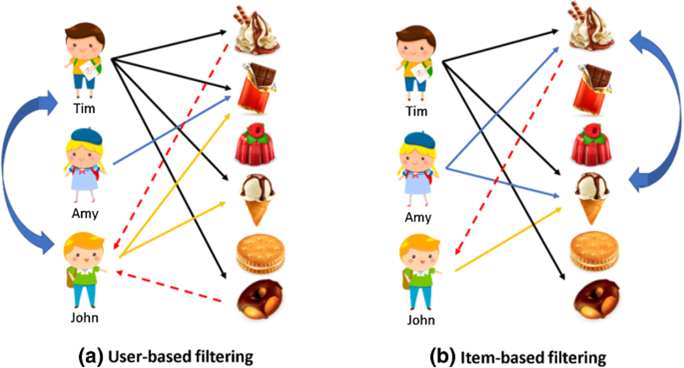  


*사용자 기반 CF (User-Based CF: UBCF)*  
- 지금까지 나온 CF추천 알고리즘 방식
- 유사도 계산 기준: 사용자
- 취향이 비슷한 이웃(neighbor)을 알아내고, 이 그룹에 속한 사용자들이 공통적으로 좋게 평가한 아이템을 추천하는 방식
- 단점
    - 데이터가 조금 바뀔 때마다 업데이트를 해야 함
    - 데이터 부족시 터무니없는 추천하는 경우가 상당히 있음
- 장점
    - 데이터가 충분하다면 UBCF가 IBCF보다 정확함
- 데이터 크기가 적고 각 사용자에 대한 충분한 정보(구매나 평가)가 있는 경우에 사용


*아이템 기반 CF (Item-Based CF: IBCF)*  
- 유사도 계산 기준: 아이템
- 사용자들의 평가 패턴을 바탕으로 아이템 간의 유사도를 계산해서 사용자의 특정 아이템에 대한 예측 평점을 계산하는 방식
    - 구체적) 예측 대상 사용자가 평가한 아이템의 평점과, 다른 각 아이템과의 유사도를 가중해서 평균한 값을 그 아이템에 대한 예측값으로 사용
- 단점
    - 정확도가 떨어짐
- 장점
    - 터무니없는 추천을 할 위험이 적음. 
    - 데이터가 조금 바뀌어도 추천 결과에 영향이 크지 않으므로 업데이트를 자주하지 않아도 됨.
- 데이터가 크거나 각 사용자에 대한 충분한 정보가 없는 경우에 사용



#### 아이템 기반 CF (IBCF)

In [55]:
# Created or modified on May 2022
# Author: 임일
# 협업필터링(CF) 추천 - Item-based CF

################# 반복 코드

import numpy as np
import pandas as pd

# 데이터 읽어 오기 
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('../Data/u.user', sep='|', names=u_cols, encoding='latin-1')
i_cols = ['movie_id', 'title', 'release date', 'video release date', 'IMDB URL', 'unknown', 
        'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 
        'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
        'Thriller', 'War', 'Western']
movies = pd.read_csv('../Data/u.item', sep='|', names=i_cols, encoding='latin-1')
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('../Data/u.data', sep='\t', names=r_cols, encoding='latin-1')

# timestamp 제거 
ratings = ratings.drop('timestamp', axis=1)
# movie ID와 title 빼고 다른 데이터 제거
movies = movies[['movie_id', 'title']]

# train, test 데이터 분리
from sklearn.model_selection import train_test_split
x = ratings.copy()
y = ratings['user_id']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y)

# 정확도(RMSE)를 계산하는 함수 
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

# 모델별 RMSE를 계산하는 함수 
def score(model):
    id_pairs = zip(x_test['user_id'], x_test['movie_id'])
    y_pred = np.array([model(user, movie) for (user, movie) in id_pairs])
    y_true = np.array(x_test['rating'])
    return RMSE(y_true, y_pred)

# train 데이터로 Full matrix 구하기  
rating_matrix = x_train.pivot(index='user_id', columns='movie_id', values='rating')

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [56]:

################ 새로운 코드
# 아이템 간의 유사도: train set의 모든 가능한 아이템 pair의 Cosine similarities 계산
from sklearn.metrics.pairwise import cosine_similarity
rating_matrix_t = np.transpose(rating_matrix)
matrix_dummy    = rating_matrix_t.copy().fillna(0)
item_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
item_similarity = pd.DataFrame(item_similarity, index=rating_matrix_t.index, columns=rating_matrix_t.index)

# 주어진 영화의 (movie_id) 가중평균 rating을 계산하는 함수, 
# 가중치는 주어진 아이템과 다른 아이템 간의 유사도(item_similarity)
def CF_IBCF(user_id, movie_id):
    if movie_id in item_similarity:      # 현재 영화가 train set에 있는지 확인
        # 현재 영화와 다른 영화의 similarity 값 가져오기
        sim_scores = item_similarity[movie_id]
        # 현 사용자의 모든 rating 값 가져오기
        user_rating = rating_matrix_t[user_id]
        # 사용자가 평가하지 않은 영화 index 가져오기
        non_rating_idx = user_rating[user_rating.isnull()].index
        # 사용자가 평가하지 않은 영화 제거
        user_rating = user_rating.dropna()
        # 사용자가 평가하지 않은 영화의 similarity 값 제거
        sim_scores = sim_scores.drop(non_rating_idx)
        # 현 영화에 대한 예상 rating 계산, 가중치는 현 영화와 사용자가 평가한 영화의 유사도
        mean_rating = np.dot(sim_scores, user_rating) / sim_scores.sum()
    else:
        mean_rating = 3.0
    return mean_rating

# 정확도 계산
score(CF_IBCF)

1.0115741436449248

앞서 나왔던 UBCF와 큰 차이가 없다는 것을 알 수 있다.